In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from cluster_toolkit import deltasigma
from cluster_toolkit import concentration as conc
from cluster_toolkit import density
import pyccl as ccl
from pyccl.background import comoving_radial_distance


class Spherical_lens():
    
    def __init__(self, mass, z, Rp=None, par_cosmo=None):
        '''
            mass: lens mass          [unit: Msun/h]
            z: lens redshift
            par_cosmo: cosmology parameters 
            Rp: radial bins to compute the profile infomation. [unit: Mpc/h]
        '''
        
        self.mass = mass
        self.z = z
        self.a = 1./(1.+z)
        
        if Rp is not None:
            self.Rp = Rp
        else:
            R_max = 10. # [unit: Mpc/h]
            self.Rp = np.logspace(-2, np.log10(R_max), 100)
                
        if par_cosmo is not None:
            self.par_cosmo = par_cosmo
        else:
            self.par_cosmo = self.par_cosmo_default()
        
        self.init_cosmo_ccl(self.par_cosmo)
        self.concentration = self.cal_concentration()
        self.rho_nfw, self.Sigma_nfw, self.DeltaSigma = self.nfw_profile_info(Rp=self.Rp)
        
        # compute theta bins w.r.t. self.Rp
        radian_to_arcmin = 3437.75
        self.theta = self.Rp/self.DA_L * radian_to_arcmin # [unit : arcmin]
        
    def par_cosmo_default(self):
        
        par_cosmo = {
            'Omega_m': 0.3166, 'A_s': 2.101e-9,
            'n_s': 0.9649, 'Omega_b': 0.0494, 'h': 0.6727,
            'w0': -1.0, 'wa': 0.0, 'm_nu': 0.06} 
        
        par_cosmo['Omega_c'] = par_cosmo['Omega_m'] - par_cosmo['Omega_b']
        
        return par_cosmo
    
    def init_cosmo_ccl(self,par_cosmo):
        
        self.cosmo = ccl.Cosmology(Omega_c=par_cosmo['Omega_c'], 
                     Omega_b=par_cosmo['Omega_b'], 
                     h=par_cosmo['h'], 
                     A_s=par_cosmo['A_s'],
                     n_s=par_cosmo['n_s'], 
                     transfer_function='boltzmann_camb',
                     matter_power_spectrum='halofit')
        
        ### init linear power spectrum P(k, z) ###
        k_max = 30 # unit [1/Mpc]
        self.k = np.logspace(-5, np.log10(k_max), num=1000)
        self.Plin = ccl.linear_matter_power(cosmo=self.cosmo, k=self.k, a=self.a) # unit [1/Mpc^3]

        # convert units to h/Mpc and (Mpc/h)^3 to use in the toolkit.
        self.k /= par_cosmo['h']
        self.Plin *= par_cosmo['h']**3
        
        # distance information to lens
        self.chi_L = comoving_radial_distance(self.cosmo, self.a)*self.par_cosmo['h'] # comoving distance [unit: Mpc/h]
        self.DA_L = self.chi_L/(1.+self.z) # angular diameter distance [unit: Mpc/h]
        

    def cal_concentration(self):
        
        concentration = conc.concentration_at_M(Mass=self.mass, k=self.k, P=self.Plin, 
                                        n_s=self.par_cosmo['n_s'], 
                                        Omega_b=self.par_cosmo['Omega_b'], 
                                        Omega_m=self.par_cosmo['Omega_m'], 
                                        h=self.par_cosmo['h'], 
                                        Mass_type='mean') # Mass_type = 'mean' or 'crit'

        print(f'concentration for M={self.mass:.2e} Msun/h halo at z={self.z}:', concentration)
        
        return concentration
        
    
    def nfw_profile_info(self, Rp):
        '''
            Compute NFW profile in 3D (self.rho_nfw)                [unit: Msun h^2 / Mpc^3]
                    projected 2D profile Σ(R) (self.Sigma_nfw)      [unit: Msun h/pc^2]
                    excess surface profile ΔΣ(R) (self.DeltaSigma)  [unit: Msun h/pc^2]
            based on cluster_tool.
            
        '''
                
        rho_nfw = density.rho_nfw_at_r(r=Rp, M=self.mass, c=self.concentration, Omega_m=self.par_cosmo['Omega_m'])
        
        Sigma_nfw = deltasigma.Sigma_nfw_at_R(R=Rp, mass=self.mass, concentration=self.concentration, Omega_m=self.par_cosmo['Omega_m'])
        
        DeltaSigma = deltasigma.DeltaSigma_at_R(R=Rp, Rs=Rp, Sigma=Sigma_nfw, mass=self.mass, concentration=self.concentration, Omega_m=self.par_cosmo['Omega_m'])
        
        return rho_nfw, Sigma_nfw, DeltaSigma
    
    
    def cal_Sigma_crit(self, z_S):
        '''
            compute Σ_crit = ( c^2 D_S ) / ( 4 pi G D_L D_SL) in [unit: Msun h/pc^2]
            
            # I'm not sure D_L, D_S, D_SL is angular diameter distance or simply comoving ...
            # if they are angular diameter distance, replace the code bit with
              D_L = chi_L/(1.+z_L) # angular diameter distance [unit: Mpc/h]
              D_S = chi_S/(1.+z_S) 
              D_SL = (chi_S-chi_L)/(1.+z_S)
            # if they are comoving 
              D_L = chi_L
              D_S = chi_S
              D_SL = chi_S-chi_L
        '''
        
        z_L = self.z
        
        a_L = 1./(1.+z_L)
        a_S = 1./(1.+z_S)
        
        # comoving distance [unit: Mpc/h]
        chi_L = self.chi_L    # computed in self.init_cosmo_ccl()
        chi_S = comoving_radial_distance(self.cosmo, a_S)*self.par_cosmo['h']
        
        D_L = chi_L/(1.+z_L)   # angular diameter distance [unit: Mpc/h]
        D_S = chi_S/(1.+z_S)
        D_SL = (chi_S-chi_L)/(1.+z_S)
        
        #D_L = chi_L           # comoving angular diameter distance  [unit: Mpc/h]
        #D_S = chi_S           # comoving angular diameter distance
        #D_SL = chi_S-chi_L    # comoving angular diameter distance


        # turn units from Mpc/h to pc/h
        D_L_pc = D_L*1e6
        D_S_pc = D_S*1e6
        D_SL_pc = D_SL*1e6

        G_cgs = 6.67e-11    # [unit: m^3 kg^-1 s^-2]
        c_cgs = 299792458   # [unit: m s^-1]

        kg_to_Msun = 5.03*1e-31
        m_to_pc = 3.24*1e-17

        G_pcMsun = G_cgs * m_to_pc**3 * kg_to_Msun**(-1)  # [unit: pc^3 Msun^-1 s^-2]
        c_pc = c_cgs * m_to_pc                            # [unit: pc s^-1]

        Sigma_crit_Msun_pc2 = c_pc**2* D_S_pc / (4.*np.pi*G_pcMsun*D_L_pc*D_SL_pc)
        
        return Sigma_crit_Msun_pc2
        

In [3]:
par_cosmology = {
    'Omega_m': 0.3166,
    'A_s': 2.101e-9,
    'n_s': 0.9649,
    'Omega_b': 0.0494,
    'h': 0.6727,
    'w0': -1.0,
    'wa': 0.0,
    'm_nu': 0.06
} # 

par_cosmology['Omega_c'] = par_cosmology['Omega_m'] - par_cosmology['Omega_b']


R_max = 10. #[unit: Mpc/h]
Rp = np.logspace(-2, np.log10(R_max), 100)

Len1 = Spherical_lens(mass=2.9e14, z=0.224, Rp=Rp, par_cosmo=par_cosmology)
Len2 = Spherical_lens(mass=2.0e14, z=0.224, Rp=Rp, par_cosmo=par_cosmology)

concentration for M=2.90e+14 Msun/h halo at z=0.224: 6.460308075833506
concentration for M=2.00e+14 Msun/h halo at z=0.224: 6.643569400806362


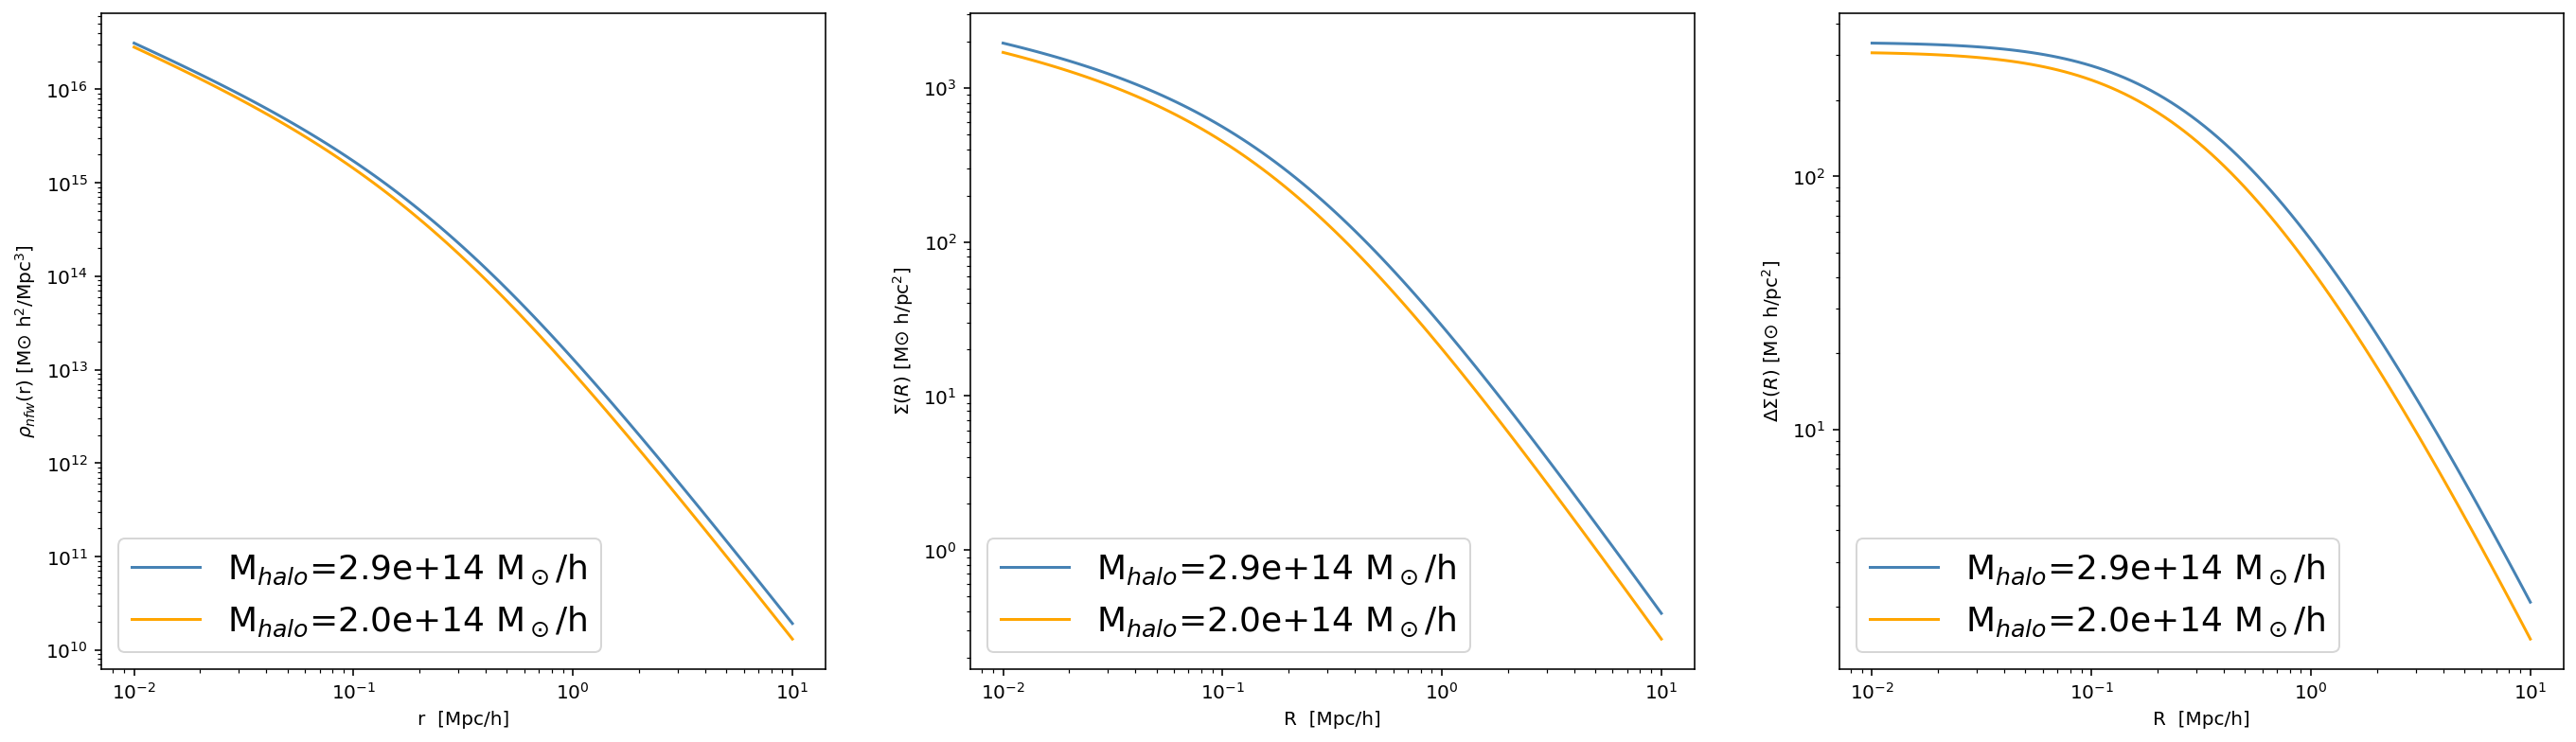

In [4]:
fig, ax = plt.subplots(1,3, figsize=(21,6.5))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.85)
plt.rc('font',size=18)

label1 = 'M$_{halo}$='+f'{Len1.mass:.1e}'+' M$_\odot$/h'
label2 = 'M$_{halo}$='+f'{Len2.mass:.1e}'+' M$_\odot$/h'

### 1st panel ###
ax[0].plot(Len1.Rp, Len1.rho_nfw, linestyle='-', label=label1, color='steelblue')
ax[0].plot(Len2.Rp, Len2.rho_nfw, linestyle='-', label=label2, color='orange')


ax[0].set_ylabel('$\\rho$$_{nfw}$(r) [M$\odot$ h$^2$/Mpc$^3$]')
ax[0].set_xlabel('r  [Mpc/h]')

### 2nd panel ###

ax[1].plot(Len1.Rp, Len1.Sigma_nfw, linestyle='-', label=label1, color='steelblue')
ax[1].plot(Len2.Rp, Len2.Sigma_nfw, linestyle='-', label=label2, color='orange')

ax[1].set_ylabel('$\Sigma(R)$ [M$\odot$ h/pc$^2$]')
ax[1].set_xlabel('R  [Mpc/h]')

### 3rd panel ###

ax[2].plot(Len1.Rp, Len1.DeltaSigma, linestyle='-', label=label1, color='steelblue')
ax[2].plot(Len2.Rp, Len2.DeltaSigma, linestyle='-', label=label2, color='orange')

ax[2].set_ylabel('$\Delta\Sigma(R)$ [M$\odot$ h/pc$^2$]')
ax[2].set_xlabel('R  [Mpc/h]')

for j in range(3):
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend(loc='best',prop={'size':18})


## critical density
## $\Sigma_{\rm crit} = \frac{c^2 D_{S}}{4 \pi G D_{SL} D_{L}}$ 

In [5]:
Sigma_crit1 = Len1.cal_Sigma_crit(z_S=0.4)
Sigma_crit2 = Len2.cal_Sigma_crit(z_S=0.4)

print('Sigma_crit1', Sigma_crit1)
print('Sigma_crit2', Sigma_crit2)

Sigma_crit1 7776.253713735787
Sigma_crit2 7776.253713735787


## convergence field

## $\kappa(R) = \frac{\Sigma(R)}{\Sigma_{\rm crit}}$

In [6]:
kappa1 = Len1.Sigma_nfw/Sigma_crit1
kappa2 = Len2.Sigma_nfw/Sigma_crit2

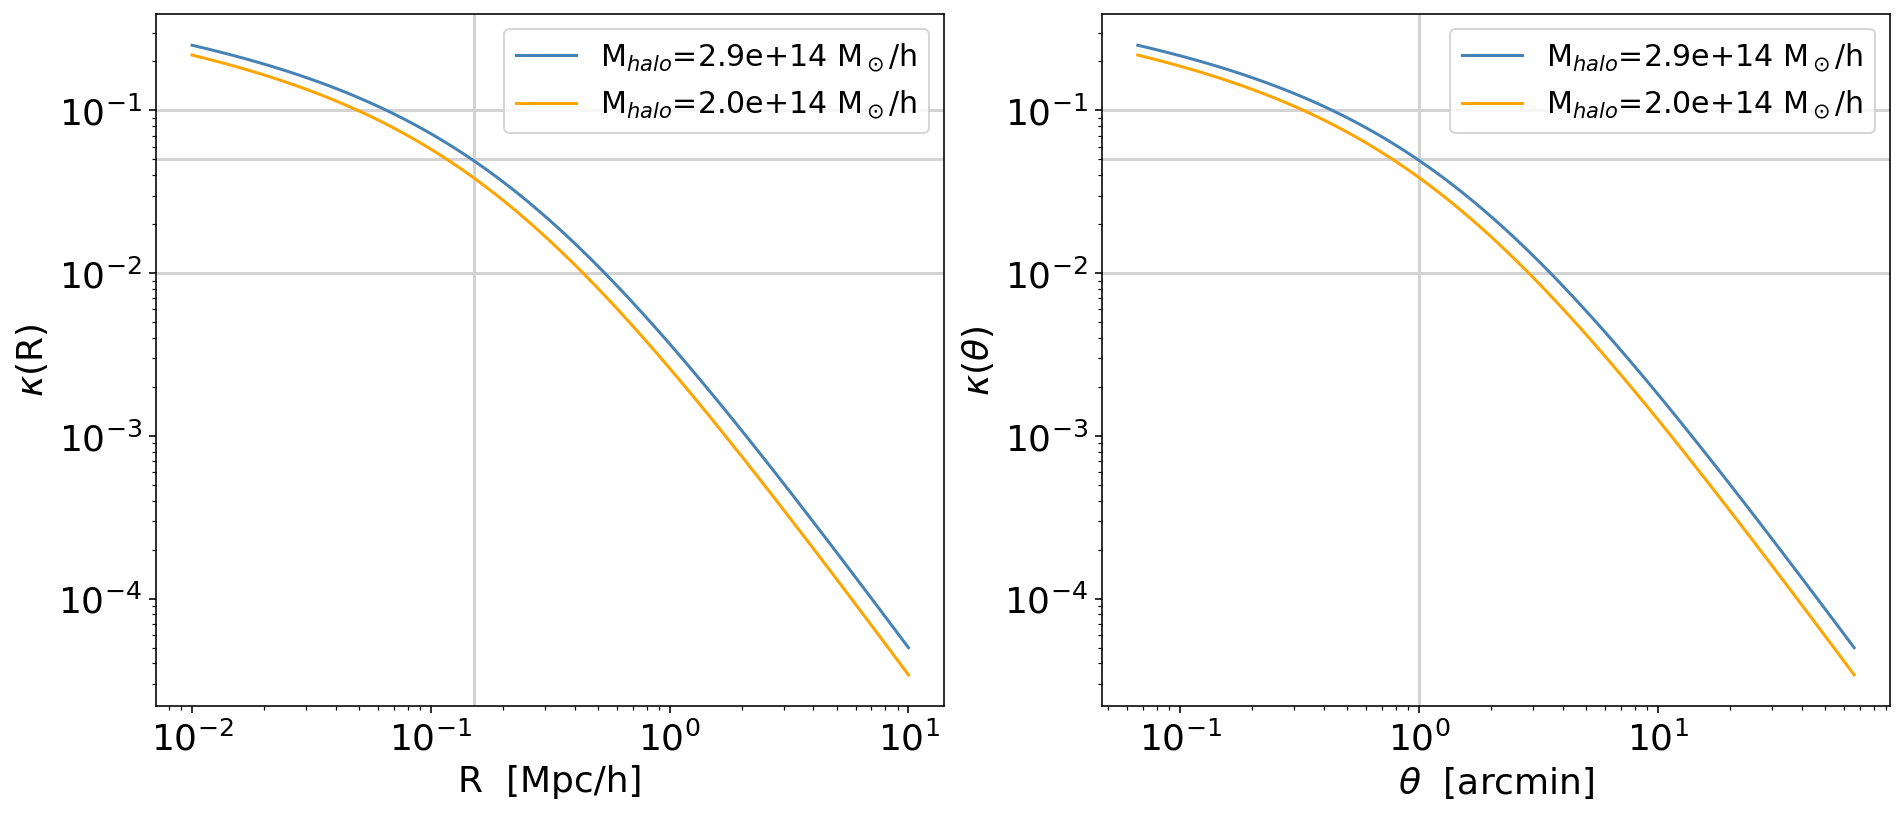

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14.,6.5))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.85)
plt.rc('font',size=16)

label1 = 'M$_{halo}$='+f'{Len1.mass:.1e}'+' M$_\odot$/h'

ax[0].plot(Len1.Rp, kappa1, linestyle='-', label=label1, color='steelblue')
ax[0].plot(Len2.Rp, kappa2, linestyle='-', label=label2, color='orange')

ax[0].set_ylabel('$\kappa$(R)')
ax[0].set_xlabel('R  [Mpc/h]')

# turn to angular scale

ax[1].plot(Len1.theta, kappa1, linestyle='-', label=label1, color='steelblue')
ax[1].plot(Len2.theta, kappa2, linestyle='-', label=label2, color='orange')

ax[1].set_ylabel('$\kappa$($\\theta$)')
ax[1].set_xlabel('$\\theta$  [arcmin]')


ax[1].axvline(x=1, color='lightgray', zorder=-10)

radian_to_arcmin = 3437.75

ax[0].axvline(x=1./radian_to_arcmin*Len1.DA_L, color='lightgray', zorder=-10)

for j in range(2):
    ax[j].axhline(y=0.1, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.05, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.01, color='lightgray', zorder=-10)


for j in range(2):
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend(loc='best',prop={'size':15})

## shear field
## $\gamma_{\rm t}(R) = \frac{\overline{\Sigma}(<R)}{\Sigma_{\rm crit}}-\frac{\Sigma(R)}{\Sigma_{\rm crit}} = \frac{\Delta\Sigma(R)}{\Sigma_{\rm crit}}$ 

In [8]:
gammat1 = Len1.DeltaSigma/Sigma_crit1
gammat2 = Len2.DeltaSigma/Sigma_crit2

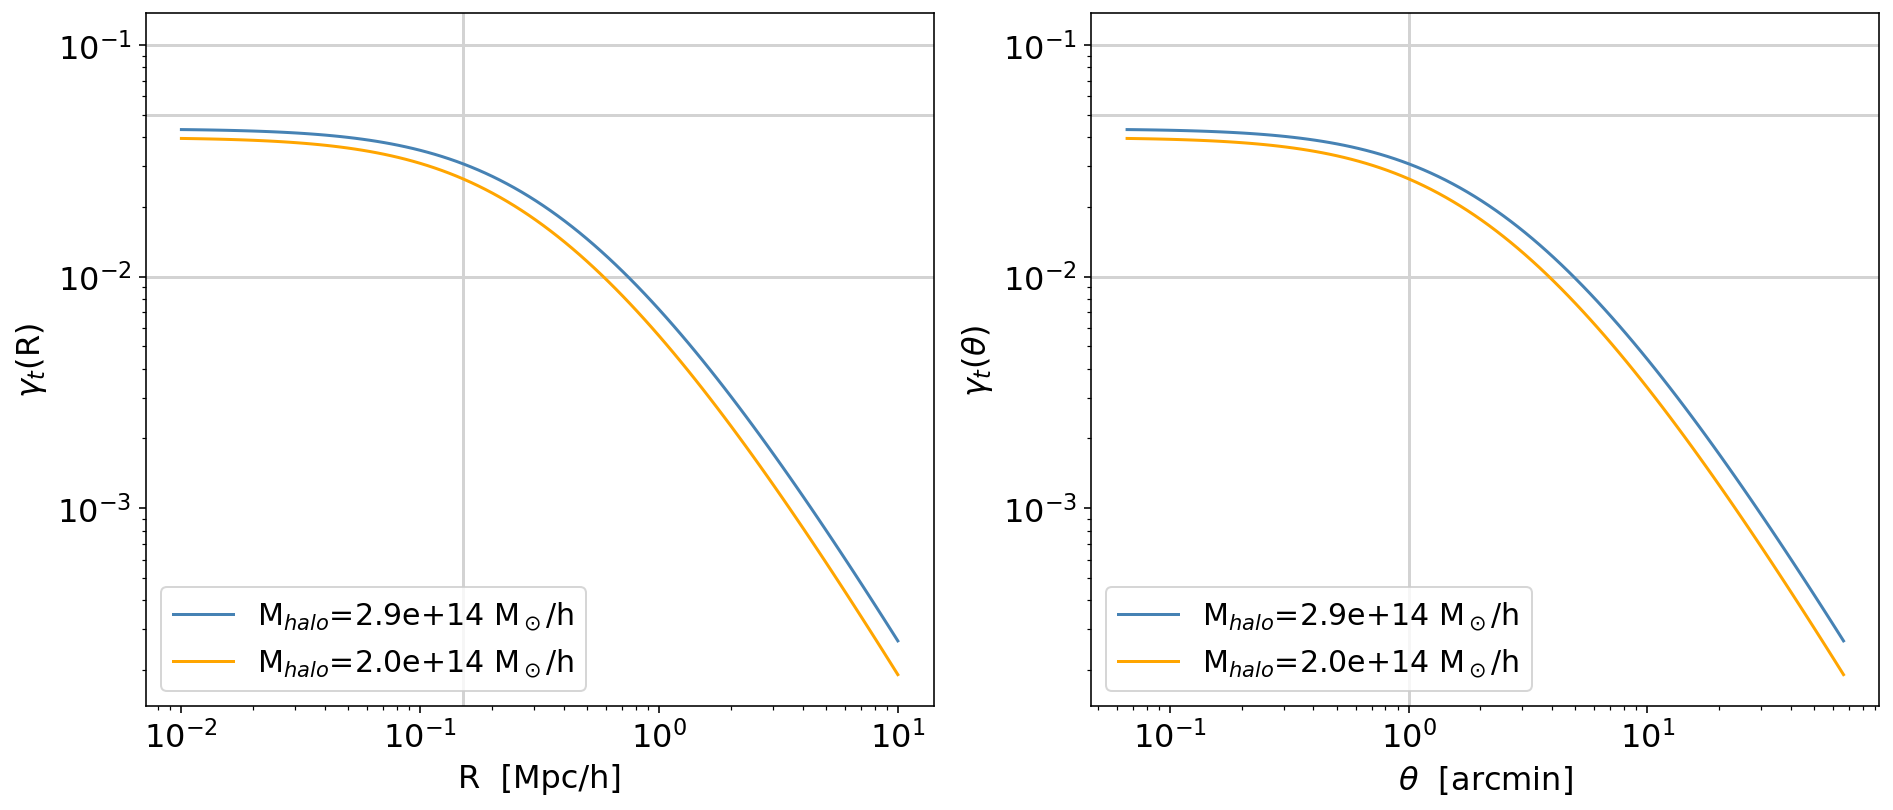

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14.,6.5))
fig.subplots_adjust(left=0.12, right=0.98, bottom=0.11, top=0.85)
plt.rc('font',size=16)

label1 = 'M$_{halo}$='+f'{Len1.mass:.1e}'+' M$_\odot$/h'
label2 = 'M$_{halo}$='+f'{Len2.mass:.1e}'+' M$_\odot$/h'



ax[0].plot(Len1.Rp, gammat1, linestyle='-', label=label1, color='steelblue')
ax[0].plot(Len2.Rp, gammat2, linestyle='-', label=label2, color='orange')


ax[0].set_ylabel('$\gamma_{t}$(R)')
ax[0].set_xlabel('R  [Mpc/h]')

# turn to angular scale

ax[1].plot(Len1.theta, gammat1, linestyle='-', label=label1, color='steelblue')
ax[1].plot(Len2.theta, gammat2, linestyle='-', label=label2, color='orange')


ax[1].set_ylabel('$\gamma_{t}$($\\theta$)')
ax[1].set_xlabel('$\\theta$  [arcmin]')


ax[1].axvline(x=1, color='lightgray', zorder=-10)
ax[0].axvline(x=1./radian_to_arcmin*Len1.DA_L, color='lightgray', zorder=-10)


for j in range(2):
    ax[j].axhline(y=0.1, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.05, color='lightgray', zorder=-10)
    ax[j].axhline(y=0.01, color='lightgray', zorder=-10)


for j in range(2):
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].legend(loc='best',prop={'size':15})

In [ ]:
Abel 2261   3x10^14